In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation


2024-01-10 12:37:40.499204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 12:37:40.499267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 12:37:40.500068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 12:37:40.506016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 12:37:41.380545: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:100]}

In [3]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

ew_input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)']

label_features=['EW_Node_Location', 'NS_Node_Location']


ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ew_input_features,
                                      label_features=label_features, pad_location_labels=1,
                                      train_val_split=0.8, stride=1, input_stride=1, padding=False,
                                      transform_features=True,
                                      input_history_steps=20, input_future_steps=20, seed=69)

=========================Creating Dataset=========================
Seed: 69
nTrain: 200 nVal: 50 (0.80)
Padding: False
Scaling: True
Horizons: 20-20 @ stride 1
Sin-Transformed features: ['Argument of Periapsis (deg)']
Padding locations (1)
Labels: ['EW_Node_Location', 'NS_Node_Location']


2024-01-10 12:38:10.638518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 12:38:10.661185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 12:38:10.661255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 12:38:10.663256: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 12:38:10.663332: I external/local_xla/xla/stream_executor

=========================Finished Dataset=========================


(TensorSpec(shape=(None, 40, 5), dtype=tf.float64, name=None), {'EW_Node_Location': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 40, 5)]           0         
                                                                 
 flatten_2 (Flatten)         (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               51456     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)             

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/david/Code/splid-challenge/base/prediction_models.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


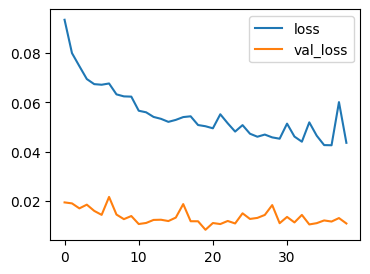

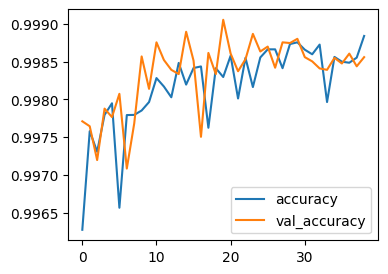

In [10]:
train_combined, val_combined = ds_gen.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True)

print(train_combined.element_spec)

#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,32],[32,16]], dense_layers=[64,32], l2_reg=0.0001, mixed_dropout=0.1, lr_scheduler=[30000,0.8], seed=0)
dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
train_combined = train_combined.map(lambda x,y:(x,y['EW_Node_Location']))
val_combined = val_combined.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights

dense_model.summary()
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=40, verbose=1, plot_hist=False, class_weight={0: 1.0, 1: 20.0}, callbacks=[])
dense_model.model.save('models/ew_localizer.hdf5')

dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [19]:
train_combined, val_combined = ds_gen.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True)
train_combined = train_combined.map(lambda x,y:(x,y['EW_Node_Location']))
val_combined = val_combined.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=40, verbose=1, plot_hist=False, class_weight={0: 1.0, 1: 20.0}, callbacks=[])


Starting training. Optimizing "val_accuracy"
Epoch 1/40
837/837 [==============================] - 18s 21ms/step - loss: 0.0452 - accuracy: 0.9982 - val_loss: 0.0132 - val_accuracy: 0.9986
Epoch 2/40
837/837 [==============================] - 17s 21ms/step - loss: 0.0377 - accuracy: 0.9984 - val_loss: 0.0098 - val_accuracy: 0.9989
Epoch 3/40
837/837 [==============================] - 18s 21ms/step - loss: 0.0359 - accuracy: 0.9985 - val_loss: 0.0096 - val_accuracy: 0.9991
Epoch 4/40
837/837 [==============================] - 17s 21ms/step - loss: 0.0440 - accuracy: 0.9982 - val_loss: 0.0105 - val_accuracy: 0.9989
Epoch 5/40
837/837 [==============================] - 17s 20ms/step - loss: 0.0373 - accuracy: 0.9985 - val_loss: 0.0101 - val_accuracy: 0.9992
Epoch 6/40
837/837 [==============================] - 18s 21ms/step - loss: 0.0376 - accuracy: 0.9983 - val_loss: 0.0133 - val_accuracy: 0.9983
Epoch 7/40
837/837 [==============================] - 18s 21ms/step - loss: 0.0412 - accura

In [ ]:
train_combined, val_combined = ds_gen.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True)
dense_model_ns = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,48],[32,32]], dense_layers=[64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[30000,0.8], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
hist = dense_model_ns.fit(train_combined, val_ds=val_combined, epochs=50, verbose=1, plot_hist=False, callbacks=[])
dense_model_ns.model.save('models/ns_localizer.hdf5')


In [11]:
def localization_eval(ds_gen, gt_path, model, train=True, with_initial_node=False, remove_consecutives=True, direction='EW'):

    t_ds, v_ds = ds_gen.get_datasets(256, label_features=[f'{direction}_Node_Location'], shuffle=False, keep_identifier=True)
    ds = t_ds if train else v_ds

    ground_truth_labels = pd.concat([split_dataframes[k] for k in ds_gen.train_keys + ds_gen.val_keys])[['ObjectID', 'TimeIndex', 'EW_Node', 'EW_Type']].rename(columns={f'{direction}_Node' : 'Node', f'{direction}_Type' : 'Type'})
    ground_truth_labels['Direction'] = direction # For now just EW, see line above
    ground_truth_labels = ground_truth_labels[(ground_truth_labels['Direction'] == direction)]

    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    labels = np.concatenate([element[f'{direction}_Node_Location'] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])

    # get predictions
    #model.evaluate(v_ds.map(lambda x,y,z:(x,y)))
    preds = model.predict(inputs)
    preds_argmax = np.argmax(preds, axis=1)

    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)
    df['Location'] = labels
    df[f'Location_Pred'] = preds_argmax

    # add initial node prediction
    if with_initial_node:
        for obj in ds_gen.train_keys if train else ds_gen.val_keys:
            df = df.sort_index()
            df.loc[-1] = [int(obj), 0, 1, 1] # objid, timeindex, location, location_pred
            df.index = df.index + 1
            df = df.sort_index()
    
    df_filtered = df.loc[(df['Location_Pred'] == 1)]
    df_filtered = df_filtered.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

    # remove consecutives detections
    # TODO: this fails when two consecutive objects have detections at exactly consecutive timeindices - a corner case I ignore for now ;)
    if remove_consecutives:
        df_filtered['consecutive'] = (df_filtered['TimeIndex'] - df_filtered['TimeIndex'].shift(1) != 1).cumsum()

        # Filter rows where any number of consecutive values follow each other
        df_filtered=df_filtered.groupby('consecutive').apply(lambda df: df.iloc[int(len(df)/2), :]).reset_index(drop=True).drop(columns=['consecutive'])

    # if localizations bundle up, remove the duplicates and choose the center

    # now, assign the real label to the locations
    mergeDf = df_filtered.merge(ground_truth_labels, how='left', on = ['ObjectID', 'TimeIndex'])

    print(mergeDf.head(20))

    ground_truth_from_file = pd.read_csv(gt_path).sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
    ground_truth_from_file = ground_truth_from_file[ground_truth_from_file['ObjectID'].isin(map(int, ds_gen.train_keys if train else ds_gen.val_keys))].copy()
    ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == direction)]

    # remove initial nodes, as they can always be localized anyway
    if not with_initial_node:
        mergeDf = mergeDf.loc[(mergeDf['TimeIndex'] != 0)]
        ground_truth_from_file = ground_truth_from_file.loc[(ground_truth_from_file['TimeIndex'] != 0)]

    evaluator = evaluation.NodeDetectionEvaluator(ground_truth_from_file, mergeDf)
    precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F2: {f2:.2f}')
    print(f'RMSE: {rmse:.4}')
    print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')

    return df.loc[(df['Location'] == 1) | (df['Location_Pred'] == 1)].merge(ground_truth_labels, how='left', on = ['ObjectID', 'TimeIndex']), evaluator, mergeDf

In [18]:
eval_df, evaluator, mergeDf = evaluation.evaluate_localizer(ds_gen, split_dataframes=split_dataframes, gt_path=challenge_data_dir / 'train_labels.csv', model=dense_model.model, train=True, with_initial_node=False, remove_consecutives=True, direction='EW', return_scores=False)
#eval_df = localization_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model_ns.model, train=False, add_initial_node=True)
# TODO: the problem is that I need to remove consecutive detections & replace them with a single one
# print(eval_df.head(50))
# 1-1: 52 9 35 0.64 | 9 0 5 0.69
# 1-5: 48 48 29 0.59 | 7 4 5 0.59
# 1-2 56 13 30 0.68 | 8 1 6 0.62

13379/13379 [==============================] - 30s 2ms/step
    ObjectID  TimeIndex  Location  Location_Pred Node Type Direction
0        103        208         1              1   AD   NK        EW
1        103        327         1              1   AD   NK        EW
2        103        334         0              1   AD   NK        EW
3        103        342         1              1   IK   HK        EW
4        105         99         1              1   AD   NK        EW
5        105        119         0              1   AD   NK        EW
6        106         68         1              1   AD   NK        EW
7        106         74         1              1   IK   HK        EW
8        107         68         1              1   AD   NK        EW
9        107         74         1              1   IK   HK        EW
10       108        180         1              1   AD   NK        EW
11       108        333         1              1   AD   NK        EW
12       109        180         1          

In [40]:
print(eval_df.loc[(eval_df['ObjectID']==212)].head(20))

['200', '189', '213', '128', '2', '13', '27', '247', '159', '83', '133', '40', '41', '7', '129', '209', '55', '99', '196', '14', '49', '95', '56', '12', '37', '191', '181', '32', '188', '23', '109', '29', '154', '183', '43', '132', '158', '25', '62', '92', '6', '96', '35', '225', '117', '94', '250', '142', '194', '219', '162', '145', '38', '166', '39', '75', '113', '18', '3', '168', '134', '118', '80', '111', '243', '57', '242', '172', '140', '179', '231', '124', '192', '174', '81', '249', '68', '70', '146', '163', '206', '89', '31', '203', '149', '195', '103', '232', '182', '64', '152', '141', '207', '108', '125', '126', '101', '151', '77', '186', '110', '16', '226', '169', '79', '59', '17', '138', '72', '180', '1', '144', '178', '246', '127', '46', '244', '130', '106', '90', '34', '175', '102', '22', '164', '112', '190', '65', '136', '156', '228', '85', '234', '217', '93', '143', '53', '131', '173', '177', '147', '150', '204', '20', '216', '155', '42', '197', '201', '135', '24', '237

['200', '189', '213', '128', '2', '13', '27', '247', '159', '83', '133', '40', '41', '7', '129', '209', '55', '99', '196', '14', '49', '95', '56', '12', '37', '191', '181', '32', '188', '23', '109', '29', '154', '183', '43', '132', '158', '25', '62', '92', '6', '96', '35', '225', '117', '94', '250', '142', '194', '219', '162', '145', '38', '166', '39', '75', '113', '18', '3', '168', '134', '118', '80', '111', '243', '57', '242', '172', '140', '179', '231', '124', '192', '174', '81', '249', '68', '70', '146', '163', '206', '89', '31', '203', '149', '195', '103', '232', '182', '64', '152', '141', '207', '108', '125', '126', '101', '151', '77', '186', '110', '16', '226', '169', '79', '59', '17', '138', '72', '180', '1', '144', '178', '246', '127', '46', '244', '130', '106', '90', '34', '175', '102', '22', '164', '112', '190', '65', '136', '156', '228', '85', '234', '217', '93', '143', '53', '131', '173', '177', '147', '150', '204', '20', '216', '155', '42', '197', '201', '135', '24', '237

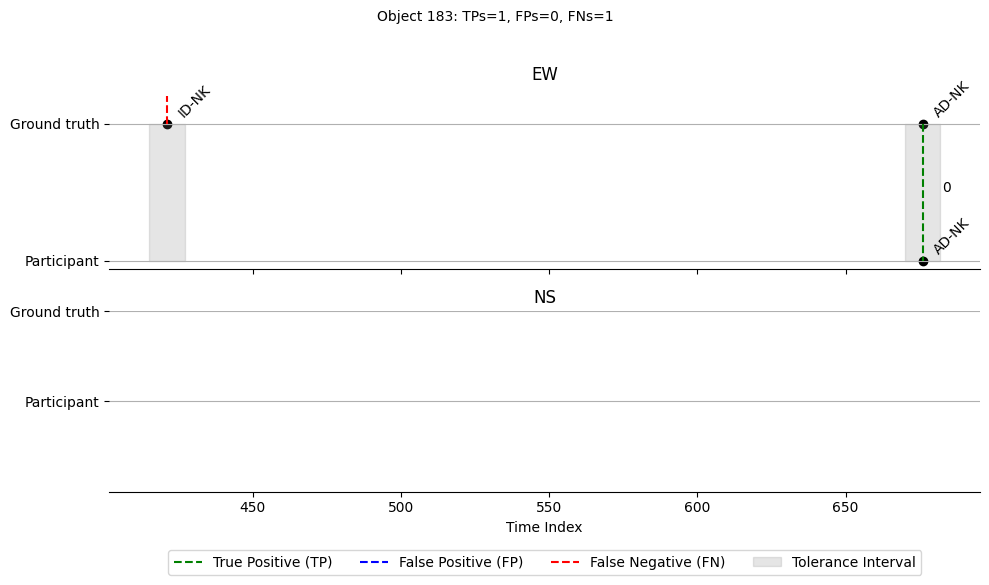

In [16]:
print(ds_gen.train_keys)
evaluator.plot(183)

In [20]:

direction = 'EW'
ground_truth_from_file = pd.read_csv(labels_dir)
ground_truth_from_file = ground_truth_from_file[ground_truth_from_file['ObjectID'].isin([121,122,123])].copy()
ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == direction)]
ground_truth_from_file = ground_truth_from_file.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

mergeDf = ground_truth_from_file.copy()
mergeDf = mergeDf.drop([4])
mergeDf.loc[-1] = [121, 817, 'EW', 'IK', 'HK']  # adding a row
mergeDf.index = mergeDf.index + 1  # shifting index
mergeDf = mergeDf.sort_index()  # sorting by index
print(mergeDf)
print(ground_truth_from_file)

evaluator = evaluation.NodeDetectionEvaluator(ground_truth_from_file, mergeDf)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F2: {f2:.2f}')
print(f'RMSE: {rmse:.4}')
print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')

    ObjectID  TimeIndex Direction Node Type
0        121        817        EW   IK   HK
1        121          0        EW   SS   NK
2        121        124        EW   AD   NK
3        121        557        EW   AD   NK
4        121        783        EW   AD   NK
6        122          0        EW   SS   NK
7        122        124        EW   AD   NK
8        122        557        EW   AD   NK
9        122        783        EW   AD   NK
10       122        816        EW   IK   HK
11       123          0        EW   SS   NK
12       123        124        EW   AD   NK
13       123        557        EW   AD   NK
14       123       1804        EW   AD   NK
    ObjectID  TimeIndex Direction Node Type
0        121          0        EW   SS   NK
1        121        124        EW   AD   NK
2        121        557        EW   AD   NK
3        121        783        EW   AD   NK
4        121        816        EW   IK   HK
5        122          0        EW   SS   NK
6        122        124        E

In [ ]:
eval_df = localization_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True, add_initial_node=True)

2024-01-06 23:47:48.838844: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1028534400 exceeds 10% of free system memory.


In [10]:
false_preds = eval_df.loc[(eval_df['Location'] != eval_df['Location_Pred'])].sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(false_preds.head(80))
false_preds = eval_df[eval_df['Location'] != eval_df['Location_Pred']]
print(len(false_preds))
print(len(eval_df))

    ObjectID  TimeIndex  Location  Location_Pred Node Type Direction
0        106         69         0              1   AD   NK        EW
1        108        179         0              1   SS   NK        EW
2        114        201         0              1   AD   NK        EW
3        116        201         0              1   AD   NK        EW
4        117        461         0              1   AD   NK        EW
5        123        125         0              1   AD   NK        EW
6        124        367         0              1   AD   NK        EW
7        129        972         1              0   IK   CK        EW
8        130         86         1              0   IK   CK        EW
9        131        155         0              1   AD   NK        EW
10       135        936         1              0   IK   CK        EW
11       139       1009         1              0   AD   NK        EW
12       139       1098         1              0   IK   CK        EW
13       141        157         1 